**Disease Diagnosis: Develop a binary classification model to diagnose an any specific disease (present or not present)
based on given symptoms or medical test results.**

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt

In [38]:
# Defininng the paths to the training and validation directories
train_dir = '/content/drive/MyDrive/Skin_cancer/Skin_Data/Training'
validation_dir = '/content/drive/MyDrive/Skin_cancer/Skin_Data/Testing'

In [39]:
# Creating ImageDataGenerator instances for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [40]:
# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 84 images belonging to 2 classes.


In [41]:
# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

Found 204 images belonging to 2 classes.


In [42]:
# Load the MobileNetV2 model, excluding the top layer
conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [43]:
# Freeze the base model
conv_base.trainable = False

In [44]:
# Build the model
model = models.Sequential([
    conv_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2914369 (11.12 MB)
Trainable params: 656

In [45]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [46]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [47]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/30
3/3 [==============================] - 12s 3s/step - loss: 1.5873 - accuracy: 0.4524 - val_loss: 1.7085 - val_accuracy: 0.2255 - lr: 0.0010
Epoch 2/30
3/3 [==============================] - 7s 3s/step - loss: 1.1120 - accuracy: 0.6429 - val_loss: 0.7398 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 3/30
3/3 [==============================] - 5s 2s/step - loss: 0.5932 - accuracy: 0.7381 - val_loss: 0.3659 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 4/30
3/3 [==============================] - 5s 2s/step - loss: 0.4079 - accuracy: 0.8095 - val_loss: 0.9171 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 5/30
3/3 [==============================] - 7s 3s/step - loss: 0.3512 - accuracy: 0.8333 - val_loss: 1.3983 - val_accuracy: 0.5245 - lr: 0.0010
Epoch 6/30
3/3 [==============================] - 5s 2s/step - loss: 0.3356 - accuracy: 0.8333 - val_loss: 0.8136 - val_accuracy: 0.6961 - lr: 0.0010
Epoch 7/30
3/3 [==============================] - 7s 3s/step - loss: 0.3524 - accuracy: 0.8810 - va

In [48]:
# Unfreeze some layers of the base model and recompile
conv_base.trainable = True
for layer in conv_base.layers[:100]:
    layer.trainable = False

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [49]:
# Train the model again
history_fine = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/30
3/3 [==============================] - 20s 4s/step - loss: 0.5615 - accuracy: 0.7500 - val_loss: 0.3632 - val_accuracy: 0.8382 - lr: 1.0000e-05
Epoch 2/30
3/3 [==============================] - 6s 3s/step - loss: 0.5622 - accuracy: 0.7500 - val_loss: 0.3597 - val_accuracy: 0.8382 - lr: 1.0000e-05
Epoch 3/30
3/3 [==============================] - 13s 6s/step - loss: 0.4795 - accuracy: 0.7738 - val_loss: 0.3578 - val_accuracy: 0.8382 - lr: 1.0000e-05
Epoch 4/30
3/3 [==============================] - 8s 4s/step - loss: 0.4982 - accuracy: 0.7381 - val_loss: 0.3578 - val_accuracy: 0.8382 - lr: 1.0000e-05
Epoch 5/30
3/3 [==============================] - 6s 2s/step - loss: 0.4901 - accuracy: 0.7500 - val_loss: 0.3580 - val_accuracy: 0.8480 - lr: 1.0000e-05
Epoch 6/30
3/3 [==============================] - 8s 3s/step - loss: 0.4641 - accuracy: 0.7381 - val_loss: 0.3594 - val_accuracy: 0.8480 - lr: 1.0000e-05
Epoch 7/30
3/3 [==============================] - 6s 2s/step - loss: 0.470

In [50]:
# Load the best model
model.load_weights('best_model.h5')

In [51]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc}')

7/7 [==============================] - 4s 463ms/step - loss: 0.3578 - accuracy: 0.8382
Validation Accuracy: 0.8382353186607361


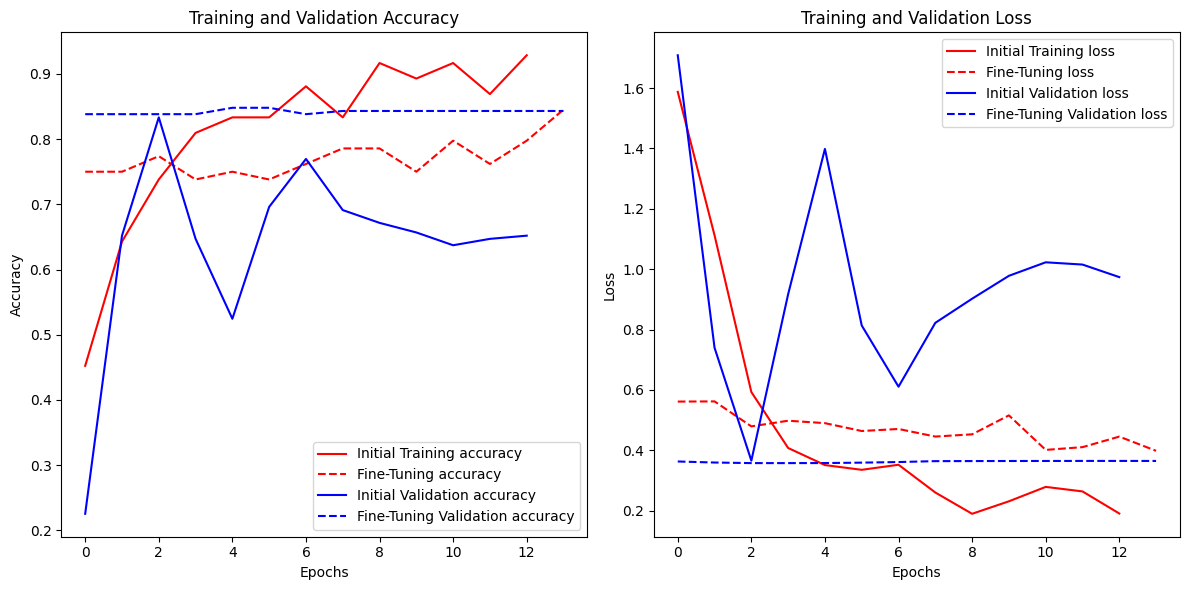

In [53]:
# Plot training history
initial_epochs = range(len(history.history['accuracy']))
fine_tuning_epochs = range(len(history_fine.history['accuracy']))

plt.figure(figsize=(12, 6))

# Plotting Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(initial_epochs, history.history['accuracy'], 'r', label='Initial Training accuracy')
plt.plot(fine_tuning_epochs, history_fine.history['accuracy'], 'r--', label='Fine-Tuning accuracy')
plt.plot(initial_epochs, history.history['val_accuracy'], 'b', label='Initial Validation accuracy')
plt.plot(fine_tuning_epochs, history_fine.history['val_accuracy'], 'b--', label='Fine-Tuning Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training Loss
plt.subplot(1, 2, 2)
plt.plot(initial_epochs, history.history['loss'], 'r', label='Initial Training loss')
plt.plot(fine_tuning_epochs, history_fine.history['loss'], 'r--', label='Fine-Tuning loss')
plt.plot(initial_epochs, history.history['val_loss'], 'b', label='Initial Validation loss')
plt.plot(fine_tuning_epochs, history_fine.history['val_loss'], 'b--', label='Fine-Tuning Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
# Save the model
model.save('skin_cancer_classifier.h5')

In [59]:
# Load and use the model for predictions
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model('skin_cancer_classifier.h5')

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        return "Cancer"
    else:
        return "Non-cancer"

# Example usage
print(predict_image('/content/drive/MyDrive/Skin_cancer/Skin_Data/Testing/Non-Cancer/1054.JPG'))

1/1 [==============================] - 1s 1s/step
Non-cancer
